In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [20]:
rng = np.random.default_rng(7)

In [21]:
def geralinear(n=200, sd=0.6):
  mean0= np.array([-1.2, -1.0])   # posição central das classes 0
  mean1= np.array([1.1, 1.0])     # posição central das classes 1
  C0 = rng.normal(mean0, [sd,sd], size=(n, 2))
  #n=3 3x2  # array das coordenadas (x1 e x2's, por isso size=(n,2)) dos pontos classificados como 0
  C1 = rng.normal(mean1, [sd,sd], size=(n, 2))  # array das coordenadas (x1 e x2´s) dos pontos classificados como classe 1

  X = np.vstack((C0, C1)) # junta em um único array as coordendadas de todos os pontos

  y = np.concatenate((np.zeros(n), np.ones(n))) # coloca as classificações de fato para todos os pontos do conjunto de dados
  return X, y     #X=(n,2)     y=(n)


In [22]:
x,y=geralinear(n=3)

print(x)
print(y)

[[-1.19926191 -0.82075268]
 [-1.36448271 -1.5343551 ]
 [-1.47280247 -1.59498793]
 [ 1.13608616  1.80412915]
 [ 0.80467609  0.62771506]
 [ 1.39390523  1.2141322 ]]
[0. 0. 0. 1. 1. 1.]


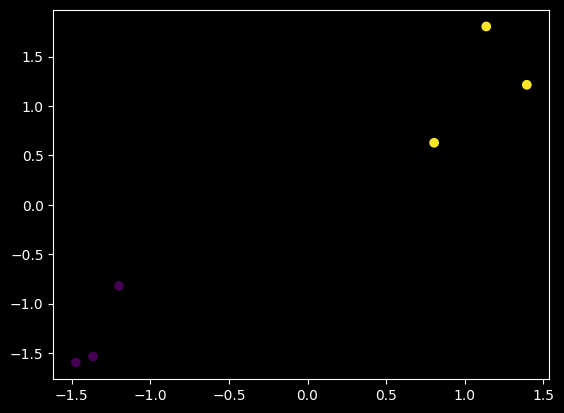

In [23]:
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

In [24]:
def designmatrix(X, grau):
  X = np.asarray(X, float)
  x1 = X[:,0:1]
  x2 = X[:, 1:1+1]
  cols = [np.ones((X.shape[0],1))]
  for i in range(grau+1):
    for j in range(grau+1-i):   # CORRIGIR ESSA LINHA: trocar o -1 por -i
      if i==0 and j==0:
        continue
      cols.append(x1**i * x2**j) # gera todos os graus possíveis até o grau máximo, incluindo
                                  # combinações entre x1 e x2, obedecendo i+j<=grau
  return np.hstack(cols)
  # retornado tem mesmo numero de linhas que X e (grau+1)*(grau+2)/2 colunas


In [25]:
designmatrix(x,2)

# y_hat = w0 + w1*x1 + w2*x2 +w3*x1^2 + w4*x2^2 + w5*x1*x2 x1*x2^2 X1^2*x2 X1^3 x2^3

array([[ 1.        , -0.82075268,  0.67363496, -1.19926191,  0.98429742,
         1.43822912],
       [ 1.        , -1.5343551 ,  2.35424558, -1.36448271,  2.09360101,
         1.86181307],
       [ 1.        , -1.59498793,  2.54398651, -1.47280247,  2.34910217,
         2.16914712],
       [ 1.        ,  1.80412915,  3.25488198,  1.13608616,  2.04964616,
         1.29069177],
       [ 1.        ,  0.62771506,  0.3940262 ,  0.80467609,  0.5051073 ,
         0.64750361],
       [ 1.        ,  1.2141322 ,  1.47411701,  1.39390523,  1.69238523,
         1.94297179]])

In [26]:
h=designmatrix(x,1)
h.shape

(6, 3)

In [27]:
def traintestsplit(X, y, test_size=0.20, seed=7):
  n= len(y)
  idx0 = np.where(y==0)[0]    # indices dos pontos em que y==0
  idx1 = np.where(y==1)[0]    # indices dos pontos em que y==1
  rng.shuffle(idx0)       # embaralha os arrays contendo os indices
  rng.shuffle(idx1)
  n0_te = int(round(test_size* len(idx0))) # numero de elementos de classe zero que o conjunto de teste deve conter
  n1_te = int(round(test_size* len(idx1))) # numero de elementos de classe um que o conjunto de teste deve conter

  # aqui juntamos o array de indices do conjunto de teste de classes zero e um
  te_idx = np.concatenate((idx0[:n0_te], idx1[:n1_te])) # indices do conjunto de teste
  # o array formado pela concatenação de idx0[de 0 até n0_te-1] e idx1[de 0 até n0_te-1] é o array de teste completo

  # Os indices restantes são correspondem aos pontos que serão usado para treinamento
  tr_idx = np.concatenate((idx0[n0_te:], idx1[n1_te:])) # indices do conjunto de treino


  rng.shuffle(te_idx) # faz um embaralhamento final dos indices do array de treinamento e teste
  rng.shuffle(tr_idx)

  return X[tr_idx], X[te_idx], y[tr_idx], y[te_idx]



In [28]:
x,y = geralinear(n=10)
X_train, X_test, y_train, y_test = traintestsplit(x,y)

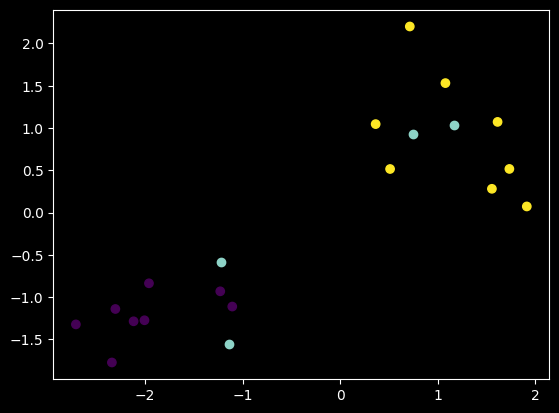

In [29]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.scatter(X_test[:,0], X_test[:,1])
plt.show()

In [30]:
def standardize_train(X): # padronização das variaveis (exceto a constante)
  X = np.asarray(X, float)
  Xs = X.copy()
  mu = X[:,1:].mean(axis=0)
  sd = X[:,1:].std(axis=0, ddof = 0)
  sd = np.where(sd==0, 1, sd)
  Xs[:,1:] = (X[:,1:] - mu)/sd
  return Xs, mu, sd

def standardize_apply(X, mu, sd): # a padronização calculada no treino deve ser aplicada ao conjunto de teste
  Xs = X.copy()
  Xs[:,1:] = (X[:,1:]-mu)/sd
  return Xs

In [31]:
def sigmoid(z):
  return 1.0/(1.0 +np.exp(-z))

In [32]:
def logloss_and_grad(w, X, y, lam):
  # z= w0 + w1*x1 + w2*x2  # w= [w0; w1; w2]
  z = X @ w

  # calcular a logloss (custo)
  loss = np.sum(np.logaddexp(0,z) - y*z)  # y = [0; 1; 0;0;0;0;1;1;0; ... 1]
                                          # z = [2 ; 3; 4 ]
  #print(loss)
  # adiciona a regularização L2 ao custo
  loss += lam*np.sum(w[1:]**2)

  # calcula as probabilidades previstas
  p= sigmoid(z)

  # Calcula o gradiente
  grad = X.T @ (p-y) # dimensão de grad é igual a de w

  # adiciona o termo de gradiente da regularização L2 (lembrando que não é aplicado a primeira coluna aqui)
  grad[1:] += 2*lam*w[1:]

  return loss/len(y), grad/len(y)

def ajustelogistico(X, y, lam=1e-2, ta=0.1, iters=2000, tol = 1e-7):

  historico_w = []
  w= np.zeros(X.shape[1])
  historico_w.append(w.copy())
  prev_loss = np.inf
  for t in range(iters):
    loss, grad = logloss_and_grad(w, X, y, lam)
    w -= ta*grad
    historico_w.append(w.copy())
    if abs(prev_loss - loss) < tol:
      break
    prev_loss = loss
  return w, np.array(historico_w)

def plot_gd(X, y ,historico_w, lam):
  w1_vals = np.linspace(historico_w[:,1].min()-1, historico_w[:,1].max()+1, 100)
  w2_vals = np.linspace(historico_w[:,2].min()-1, historico_w[:,2].max()+1, 100)
  w1_grid, w2_grid = np.meshgrid(w1_vals, w2_vals)

  #w1vals [1, 2, 3]
  #w2vals [1, 2, 3]

  #w1grid [1, 2, 3]
  #       [1, 2, 3]    1,
  #       [1, 2, 3]

  #w2grid [1, 1, 1]
  #       [2, 2, 2]
  #       [3, 3, 3]

#



  loss_grid = np.zeros_like(w1_grid)

  constfinal = historico_w[-1,0]  # [1 2 3; xxxxxx ;  3 5 2]


  for i in range(len(w1_vals)):
    for j in range(len(w2_vals)):
      w_ij =np.array([constfinal, w1_grid[i,j], w2_grid[i,j]])
      loss_grid[i,j], _ = logloss_and_grad(w_ij, X, y, lam)

  plt.figure(figsize=(8,6))
  plt.contourf(w1_grid, w2_grid, loss_grid, levels=20, cmap='viridis', alpha=0.5)
  plt.colorbar(label="Custo")
  plt.plot(historico_w[:,1],historico_w[:,2], 'r-o')
  plt.xlabel("W1 ")
  plt.ylabel("W2")
  plt.legend()
  plt.show()





In [33]:
X_o ,y = geralinear(n=100, sd=0.3)
d = 1
lam=0.01

X = designmatrix(X_o, d)
Xp, mu, sd = standardize_train(X)
w_final, historico= ajustelogistico(X, y, lam, ta=0.5, iters=100)

historico.shape
print(w_final)

[0.13851076 2.04850414 2.41380835]


In [34]:
def geracrescentes(n=200, sd=0.1):
  m=n//2
  theta = rng.uniform(0, np.pi, m)
  x1 = np.c_[np.cos(theta), np.sin(theta)]
  x2 = np.c_[1-np.cos(theta),  -np.sin(theta) - 0.1]
  X = np.vstack([x1,x2]) + rng.normal(0,sd, size=(2*m,2))

  y=np.concatenate((np.zeros(m), np.ones(m)))
  return X, y


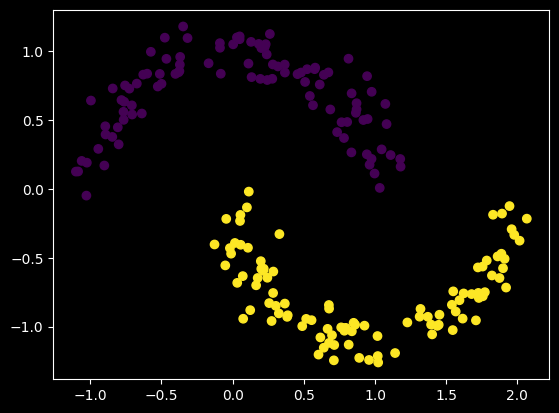

In [35]:
X_o, y = geracrescentes(n=200)
plt.scatter(X_o[:,0], X_o[:,1], c=y)
plt.show()

In [36]:
d = 3
lam=0.00

X = designmatrix(X_o, d)
Xp, mu, sd = standardize_train(X)
w_final, historico= ajustelogistico(X, y, lam, ta=0.5, iters=100)

historico.shape
print(w_final)
plotarlimites(X_o,y,mu,sd,w_final,d)

[-0.17955222 -2.79521819 -0.05140981 -1.52023858  0.10118447 -0.75654301
  0.32338236 -0.98748275 -1.15612504  0.64429343]


NameError: name 'plotarlimites' is not defined

In [ ]:
def geracircular(n = 200, r0=0.9, sd=0.05):
  X = rng.uniform(-1.5,1.5, size=(n,2))
  r = np.sqrt((X**2).sum(1))
  y= (r > r0).astype(int)
  flip = rng.random(n)< sd
  y[flip]= 1-y[flip]

  return X,y

[-1.56623037 -0.20169208  2.27155143 -0.01217325  0.12662134  2.26583786]


/tmp/ipython-input-361150800.py:14: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(gx1,gx2, pg, level = np.linspace(0,1,11), alpha=0.3)


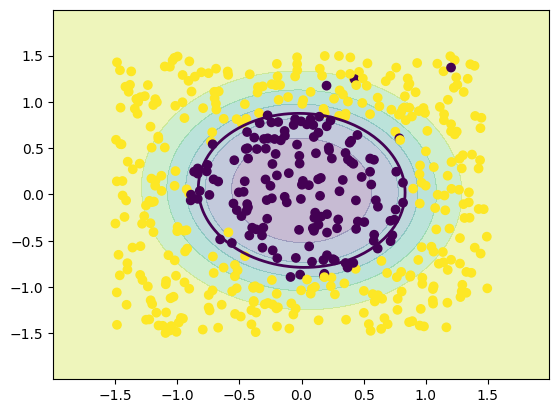

In [ ]:
X_o ,y = geracircular(n=500,sd=0.02)
d = 2
lam=0.01

X = designmatrix(X_o, d)
Xp, mu, sd = standardize_train(X)
w_final, historico= ajustelogistico(X, y, lam, ta=0.5, iters=100)

historico.shape
print(w_final)

plotarlimites(X_o,y,mu,sd,w_final,d)

In [ ]:
import plotly.graph_objects as go
## arrumar esa parte
x1_vals = np.linspace(X_o[:,0].min()-0.5, X_o[:,0].max()+0.5, 100)
x2_vals = np.linspace(X_o[:,1].min()-0.5, X_o[:,1].max()+0.5, 100)
x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)
zg = np.zeros_like(x1_grid)

for i in range(len(x1_vals)):
  for j in range(len(x2_vals)):
    pts= np.array([[x1_grid[i,j], x2_grid[i,j]]])
    X_pts = designmatrix(pts, d)
    pts_s = standardize_apply(X_pts, mu, sd)
    zg[i,j] = pts_s @ w_final


surface = go.Surface(x=x1_grid, y=x2_grid, z=zg, opacity=0.3)
scatter = go.Scatter3d(x=X_o[:,0], y=X_o[:,1], z=np.zeros_like(y), mode='markers', marker=dict(color=y, colorscale='RdBu', size=4))



fig = go.Figure(data=[surface, scatter])
fig.show()

/tmp/ipython-input-3366252720.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



/tmp/ipython-input-2463151395.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


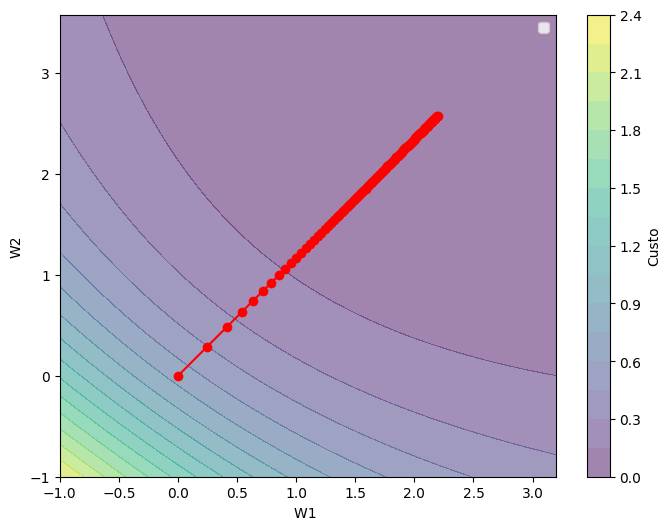

In [ ]:
plot_gd(X, y, historico, lam)

In [ ]:
def plotarlimites(X, y, mu, sd, w, grau):
  x1min, x1max = X[:,0].min()-0.5, X[:,0].max()+0.5
  x2min, x2max = X[:,1].min()-0.5, X[:,1].max()+0.5

  gx1 , gx2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max,100))

  Xg = np.c_[gx1.ravel(),gx2.ravel()]
  Xg_design = designmatrix(Xg, grau)
  Xg_design_p = standardize_apply(Xg_design, mu, sd)
  zg = Xg_design @ w
  pg = 1.0/ (1.0+ np.exp(-zg)).reshape(gx1.shape)
  plt.figure()
  plt.contour(gx1,gx2, pg, levels= [0.5], linewidths=2)
  plt.contourf(gx1,gx2, pg, level = np.linspace(0,1,11), alpha=0.3)
  plt.scatter(X[:,0], X[:,1], c=y)
  plt.show()

In [37]:
def traintestsplitMC(X, y, test_size=0.25, seed=7):

    n = len(y)
    rng = np.random.default_rng(seed)

    # Pega os indices de cada classe
    indicesporclasse = [np.where(y == c)[0] for c in np.unique(y)]

    tr_idx, te_idx = [], []

    # Embaralha os indices de cada classe
    for indices in indicesporclasse:
        rng.shuffle(indices)
        n_te = int(round(test_size * len(indices)))
        te_idx.append(indices[:n_te])
        tr_idx.append(indices[n_te:])

    # concatena os conjuntos de indices de cada classe, assim como era feito no caso binario
    # A diferença é que aqui vc tem uma lista com varios arrays, enquanto na versão
    # anterior vc tinha apenas dois arrays
    tr_idx = np.concatenate(tr_idx)
    te_idx = np.concatenate(te_idx)
    rng.shuffle(tr_idx)
    rng.shuffle(te_idx)

    return X[tr_idx], X[te_idx], y[tr_idx], y[te_idx]


X_tr_o, X_te_o, y_tr, y_te = traintestsplitMC(X_o, y, test_size=0.3, seed=7)
print(f"Train shapes: X={X_tr_o.shape}, y={y_tr.shape}")
print(f"Test shapes:  X={X_te_o.shape}, y={y_te.shape}")


def softmax(Z):
    # a função softmax substitui a sigmoide

    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def loglossgradMC(W, X, y, lam):
    """

    W: matriz de coeficientes (num_features, num_classes)
    X: Design matrix (num_amostras, num_features)
    y: classes reais como inteiros (0, 1, ..., K-1) sendo K o número de classes O tamanhos de y é igual a num_amostras

    lembrando que aqui o num_features não é só dos features escolhidos do dataframe,
    mas também do grau escolhido e também com uma coluna a mais para intercepto.
    Por enquanto usamos apenas 2 features do data frame, então o num_features é
    (grau+1)*(grau+2)/2

    lam: L2 força de regularização
    """
    N, D = X.shape
    K = W.shape[1]

    # One-Hot Encode
    # cria um array que codifica as classes no seguinte formato:
    # Y_one_hot[0,:] = [0, 0, 1] isso indica que o elemento zero é da classe K-1 (K=3)
    Y_one_hot = np.zeros((N, K))  # inicia como um array de zeros
    Y_one_hot[np.arange(N), y] = 1  # o array terá 1 apenas na posição correspondente a sua classe

    # Calcula z e as probabilidades para cada classe
    Z = X @ W  # X(N,D)  W(D,K)  ->  Z(N,K)
    P = softmax(Z)  # Probabilidades calculada com a softmax. P tem mesma dimensão de Z e Y_one_hot

    #o calculo da perda é de certa forma mais simples por conta de como as classes são separadas
    loss = -np.sum(Y_one_hot * np.log(P)) / N  #Soma todos as log(Probs) de todas a previsões da classe correta.

    # Adiciona a penalização L2 (ridge) (Excluindo o termo constante (intercepto, vies))
    l2_penalty = (lam / 2) * np.sum(W[1:, :]**2)
    loss += l2_penalty

    #Calcula o gradiente da mesma maneira. Unica diferença é o formato da matriz
    # de gradiente
    grad = (X.T @ (P - Y_one_hot)) / N

    # Adiciona tambem o gradiente da penalização: lam/2*W^2 -> 2*lam/2*W^(2-1)
    grad[1:, :] += lam * W[1:, :]

    return loss, grad

def ajustelogisticoMC(X, y, K, lam=1e-2, ta=0.1, iters=2000, tol=1e-7):
    """
    X: Design matrix (num_amostras, num_features)
    y: classes reais como inteiros (0, 1, ..., K-1) sendo K o número de classes

    lembrando novamente que o num_features não é só dos features escolhidos do dataframe,
    mas também do grau escolhido e também com uma coluna a mais para intercepto.
    Por enquanto usamos apenas 2 features do data frame, então o num_features é
    (grau+1)*(grau+2)/2

    """
    N, D = X.shape

    # inicializando W com num_features linhas e num_classes colunas
    W = np.zeros((D, K))
    prev_loss = np.inf

    # aqui é tudo semelhante ao caso binário
    for t in range(iters):

        loss, grad = loglossgradMC(W, X, y, lam)

        W -= ta * grad

        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss

    return W


# funções de validação cruzada ajustadas para o caso multiclasse
def kfolds_idxMC(y, k=5, seed=42, shuffle=True):
  y = np.asarray(y, int)

  indicesporclasse = [np.where(y == c)[0] for c in np.unique(y)]

  rng = np.random.default_rng(seed)

  foldsporclasse = []
  for indices in indicesporclasse:
    rng.shuffle(indices)
    foldsporclasse.append(np.array_split(indices, k))


      # Combine the splits to create the final folds
  folds = []
  for i in range(k):
    fold_i = np.concatenate([class_splits[i] for class_splits in foldsporclasse])
    folds.append(fold_i)

  return folds

# essa função é praticamente igual a cv_grid, porém chamando as versões MC
def cv_gridMC(X , y , graus, lambdas, k= 5, seed =42, ta=0.1, iters=2000):

    folds = kfolds_idxMC(y_tr, k=k, seed=seed)
    results = []
    num_classes = len(np.unique(y_tr))

    for d in graus:
        for lam in lambdas:
            losses = []
            for f in range(k):

                va_idx = folds[f]
                tr_idx = np.concatenate([folds[i] for i in range(k) if i != f])
                Xtr_fold = designmatrix(X[tr_idx], d)
                Xva_fold = designmatrix(X[va_idx], d)
                Xtr_s, mu, sd = standardize_train(Xtr_fold)
                Xva_s = standardize_apply(Xva_fold, mu, sd)

                W = ajustelogisticoMC(Xtr_s, y_tr[tr_idx], K=num_classes, lam=lam, ta=ta, iters=iters)


                val_loss, _ = loglossgradMC(W, Xva_s, y_tr[va_idx], lam)
                losses.append(val_loss)

            results.append((float(np.mean(losses)), d, float(lam)))

    best = min(results, key=lambda t: t[0])
    return results, best

def predict_proba_MC(Xs, W):

    return softmax(Xs @ W)

def predict_MC(Xs, W):

    probas = predict_proba_MC(Xs, W)
    return np.argmax(probas, axis=1)


def plotarlimitesMC(X_raw, y, mu, sd, W, degree, title = "diga algo"):

    x1min, x1max = X_raw[:,0].min() - 5, X_raw[:,0].max() + 5
    x2min, x2max = X_raw[:,1].min() - 5, X_raw[:,1].max() + 5

    gx1, gx2 = np.meshgrid(np.linspace(x1min, x1max, 200),
                           np.linspace(x2min, x2max, 200))

    Xg_raw = np.c_[gx1.ravel(), gx2.ravel()]
    Xg_poly = designmatrix(Xg_raw, degree)
    Xg_s = standardize_apply(Xg_poly, mu, sd)

    # faz a previsão para cada ponto do grid. Isso permite dar o efeito de preenchimento de cada região
    Z = predict_MC(Xg_s, W).reshape(gx1.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(gx1, gx2, Z, alpha=0.3, cmap='viridis')
    scatter = plt.scatter(X_raw[:,0], X_raw[:,1], c=y, cmap="viridis", s=50, edgecolor="k", linewidth=0.5)

    handles, _ = scatter.legend_elements()
    legend_labels = list(species_map.keys())
    plt.legend(handles, legend_labels, title="Species")

    plt.title(title)
    plt.xlabel(feature_cols[0])
    plt.ylabel(feature_cols[1])
    plt.show()

Train shapes: X=(140, 2), y=(140,)
Test shapes:  X=(60, 2), y=(60,)
